# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import cross_val_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
portfolio.shape

(10, 6)

In [4]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [5]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [6]:
portfolio.offer_type.value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

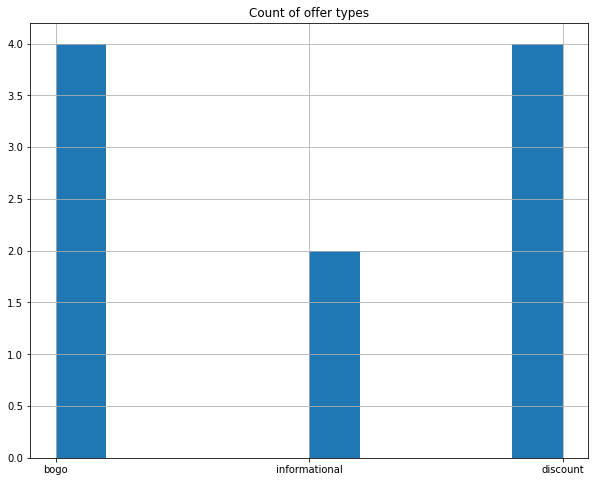

In [7]:
plt.figure(figsize =(10,8))
portfolio.offer_type.hist(bins = 10)
plt.title('Count of offer types')
plt.legend;

# Profile


In [8]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [9]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [10]:
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [11]:
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

In [12]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [13]:
profile[profile.age == 118]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [14]:
profile = profile[profile.age != 118]

In [15]:
profile.shape

(14825, 5)

In [16]:
profile.age.value_counts()

58     408
53     372
51     363
59     359
54     359
      ... 
100     12
96       8
98       5
101      5
99       5
Name: age, Length: 84, dtype: int64

<AxesSubplot:xlabel='age'>

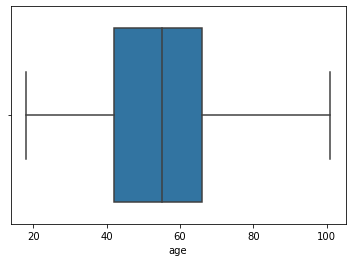

In [17]:
sns.boxplot(profile['age'])

#### customers above 70 do not use the starbucks application that much.

In [18]:
profile.describe()

,age,became_member_on,income
count,14825.000000,1.482500e+04,14825.000000
mean,54.393524,2.016689e+07,65404.991568
std,17.383705,1.188565e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016052e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [19]:
profile[(profile['age'] > 60) & (profile['age'] <= 101)]

,gender,age,id,became_member_on,income
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
13,F,61,aa4862eba776480b8bb9c68455b8c2e1,20170911,57000.0
15,F,62,31dda685af34476cad5bc968bdb01c53,20160211,71000.0
...,...,...,...,...,...
16988,M,64,f653cf2d8bba42d0a53c2937ee2e5893,20180104,51000.0
16990,F,70,79edb810789c447e8d212a324b44cc16,20160310,39000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


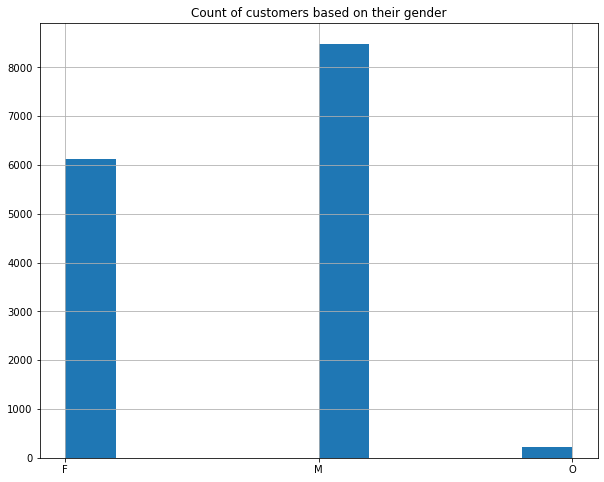

In [20]:
plt.figure(figsize =(10,8))
profile.gender.hist(bins = 10)
plt.title('Count of customers based on their gender')
plt.legend;

# Transcript DF

In [21]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [22]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [23]:
transcript.shape

(306534, 4)

In [24]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


<AxesSubplot:>

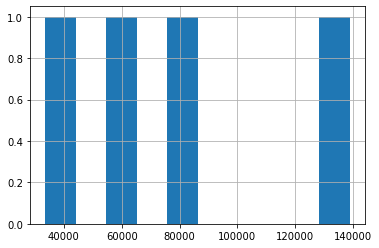

In [25]:
transcript.event.value_counts().hist()

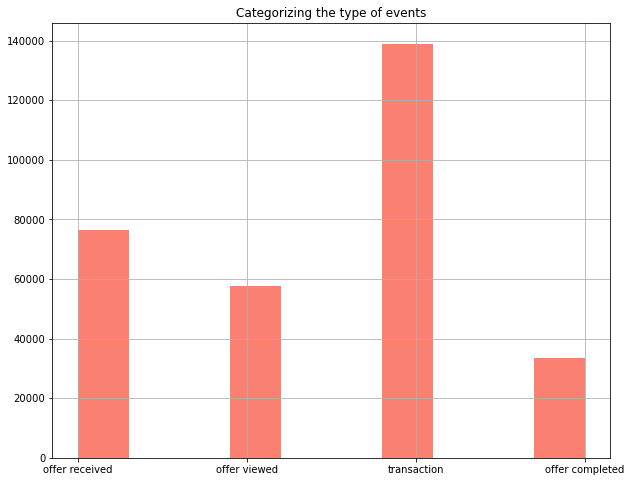

In [26]:
plt.figure(figsize =(10,8))
transcript.event.hist(bins = 10, color = 'salmon')
plt.title('Categorizing the type of events')
plt.legend;

# Data Cleaning

In this section, I'll do the following:
    1- rename some columns for better accessibility. 
    2- remove customers above 70 as they wouldn't use the app that much as seen from the boxplot in the data exploration section.
    3- categorize the age column into 4 groups (teens, young_adults, mid_aged_adults,old_aged_adults).



In [27]:
def column_rename(df, new_name):
    """"
    Parameters:
    df: The dataframe containing the columns to rename
    new_name: the new renamed column
    
    Returns:
    
    df: The dataframe containing the renamed columns
    
    """
    df = df.rename(columns = new_name)
    
    return df

    

In [28]:
profile.head(1)

,gender,age,id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [29]:
portfolio.head(1)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [30]:
transcript.head(1)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0


In [31]:
new_name = {'id':'Customer_ID','became_member_on':'joining_date', 'income':'Customer_income'}
profile_df= column_rename(profile, new_name)

In [32]:
profile_df.head(1)

,gender,age,Customer_ID,joining_date,Customer_income
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0


In [33]:
new_name = {'id':'Offer_ID'}
portfolio_df = column_rename(portfolio, new_name)

In [34]:
portfolio_df.head(1)

,reward,channels,difficulty,duration,offer_type,Offer_ID
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd


In [35]:
new_name = {'person' :'Customer_ID'}
Transcript_df = column_rename(transcript, new_name)

In [36]:
Transcript_df

,Customer_ID,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [37]:
Transcript_df['Offer_ID'] = Transcript_df['value'].apply(lambda x: x.get('offer_id'))
Transcript_df['Offer ID'] = Transcript_df['value'].apply(lambda x: x.get('offer id'))
Transcript_df['Profit'] = Transcript_df['value'].apply(lambda x: x.get('reward'))
Transcript_df['Loss'] = Transcript_df['value'].apply(lambda x: x.get('amount'))


In [38]:
Transcript_df.head(1)

,Customer_ID,event,value,time,Offer_ID,Offer ID,Profit,Loss
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,None,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN


In [39]:
# Merging offer id and offer_id into offer_id column
Transcript_df['Offer_ID'] = Transcript_df.apply(lambda x : x['Offer ID'] if x['Offer_ID'] == None else x['Offer_ID'], axis = 1)


In [40]:
Transcript_df.drop(['Offer ID','value'], axis = 1, inplace=True)
Transcript_df.fillna(0, inplace= True)

In [41]:
def category(df):
    """
    Parameters:
    df: Input Dataframe 
    
    Returns:
    
    df: Dataframe with categorized age groups
    
      
    """
    df.loc[(df.age<20), 'Group'] = 'Teenager'
    df.loc[(df.age>=20) & (df.age<40), 'Group'] = 'Young_Adult'
    df.loc[(df.age>=40) & (df.age<60), 'Group'] = 'Mid_Aged_Adult'
    df.loc[(df.age>=60) & (df.age<110), 'Group'] = 'Old_Aged_Adult'
    
   
    
    return df

In [42]:
profile_df = category(profile_df)

In [43]:
profile_df.head(1)

,gender,age,Customer_ID,joining_date,Customer_income,Group
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0,Mid_Aged_Adult


# EDA - Exploratory Data Analysis

In this section I'll do the following:
    1- Merge the three dataframe together into one dataframe
    2- Analysis the Dataframe
    3- Clean and prepare the data
    4- Build an ML model & train the data
    
    

In [44]:
def merging(profile_df, portfolio_df, Transcript_df):
    """
    Merging the three dataframes into one DF
    
    Parameters:
    profile_df: the cleaned profile dataframe
    portfolio_df: the cleaned portfolio dataframe
    Transcript_df: the cleaned transcript dataframe
    
    Returns:
    df: the dataframe combining all three Dataframes together
    """
    
    df = pd.merge(portfolio_df,Transcript_df, on= 'Offer_ID')
    df = pd.merge(df, profile_df, on = 'Customer_ID')
    
    return df
    
    



In [45]:
df = merging(profile_df, portfolio_df, Transcript_df)

In [46]:
df.isnull().sum()

reward             0
channels           0
difficulty         0
duration           0
offer_type         0
Offer_ID           0
Customer_ID        0
event              0
time               0
Profit             0
Loss               0
gender             0
age                0
joining_date       0
Customer_income    0
Group              0
dtype: int64

In [47]:
df.head(1)

,reward,channels,difficulty,duration,offer_type,Offer_ID,Customer_ID,event,time,Profit,Loss,gender,age,joining_date,Customer_income,Group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,64,20170909,100000.0,Old_Aged_Adult


#### Changing the date formation of joining_date column 

In [48]:
df['joining_date'] = df['joining_date'].apply(lambda x: pd.to_datetime(str(x), format = '%Y%m%d'))

### Plotting age group distribution of the customers

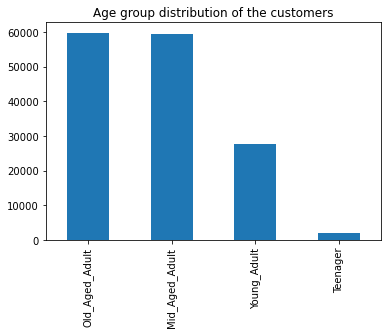

In [49]:
df.Group.value_counts().plot.bar(title = 'Age group distribution of the customers')
plt.legend;

#### As we can observe from the above bar plot, The majority of the customers are above 40 and the lowest percentage of customers using the app are for young adults and teenagers, which is quite shocking.

### Plotting Age groups relative to their income

<AxesSubplot:xlabel='Group', ylabel='Customer_income'>

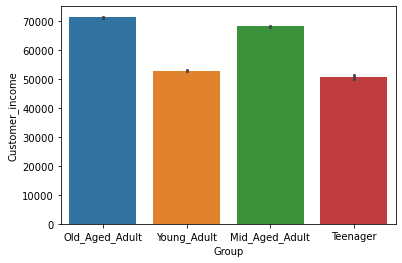

In [50]:
sns.barplot(data = df, x= df['Group'], y= df['Customer_income'])

In [51]:
df.Customer_income.mean()

66414.11914922214

### Plotting the number of used offers relative to customer's salary

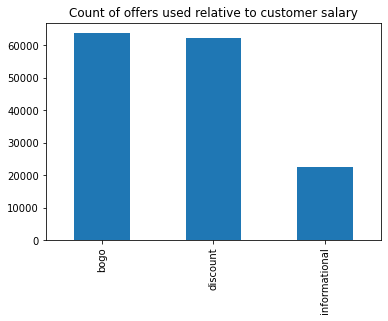

In [52]:
df.offer_type.value_counts().plot.bar(title = 'Count of offers used relative to customer salary')
plt.legend;

#### As seen from the above chart, 'BOGO' and ' 'Discount' are mostly used by customers

### Plotting the Type of offer used relative to Age group

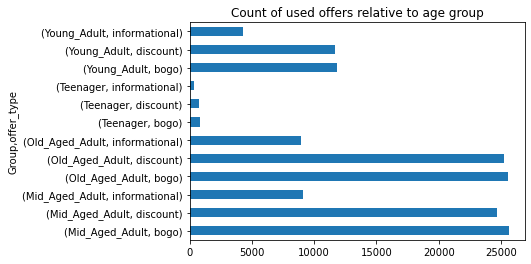

In [53]:
df.groupby('Group')['offer_type'].value_counts().plot.barh(title = 'Count of used offers relative to age group')
plt.legend;

#### From the plot above we can conclude the for all the age groups, discount and bogo are mostly picked by them with informational being the least to be picked.

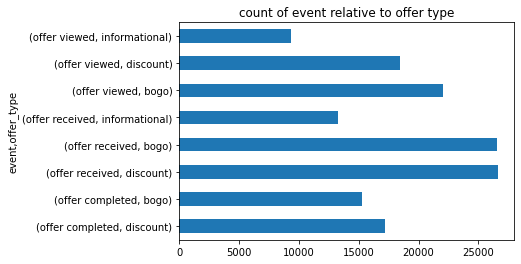

In [54]:
df.groupby('event')['offer_type'].value_counts().plot.barh(title = 'count of event relative to offer type')
plt.legend;

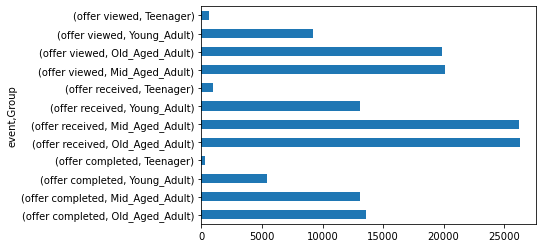

In [55]:
df.groupby('event')['Group'].value_counts().plot.barh('count of the event relative to age group')
plt.legend;

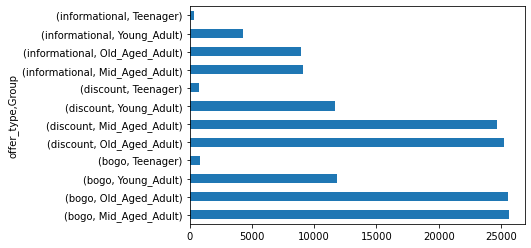

In [56]:
df.groupby('offer_type')['Group'].value_counts().plot.barh('count of the event relative to age group')
plt.legend;


#### As we can see from the above two plots, offers are mostly viewed and picked by both mid-aged and old-aged customers, with the least percentage to the teenagers. Also, the most picked offer is the 'discount' offer.

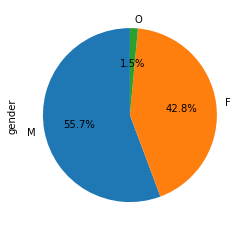

In [57]:
df.gender.value_counts().plot(kind = 'pie', autopct = '%1.1f%%', startangle = 90);

#### The majority of the customers are Male with around 56% while female customers are around 43%

<AxesSubplot:ylabel='gender,event'>

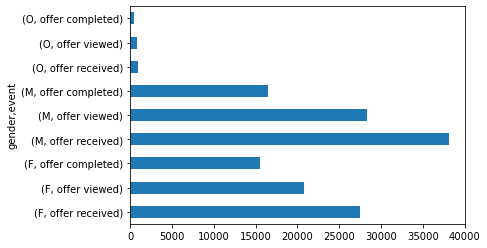

In [58]:
df.groupby('gender')['event'].value_counts().plot.barh()

In [59]:
completed_male = df.query('gender == "M" & event == "offer completed"')['event'].count()
total_male = df.query('gender == "M"')['event'].count()
pct_male = completed_male/total_male * 100
print("Percentage of Male customers completing the received offer", round(pct_male),"%")

completed_female = df.query('gender == "F" & event == "offer completed" ')['event'].count()
total_female = df.query('gender == "F"')['event'].count()
pct_female = completed_female/total_female * 100
print("Percentage of Female customers completed the received offer", round(pct_female),"%")

Percentage of Male customers completing the received offer 20 %
Percentage of Female customers completed the received offer 24 %


#### from the above two charts, we can see that Men customers are higher in numbers than female customer. But, the percentage of women completing the offer relative to their total count is higher than men who completed the offer relative to their total count.

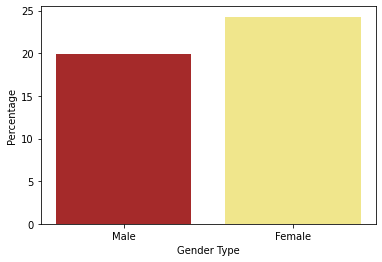

In [60]:
x= [1,2]
y= [pct_male,pct_female]
colors = ['brown', 'khaki']
labels = ["Male", "Female"]
plt.bar(x,y, tick_label= labels, color = colors)
plt.xlabel("Gender Type")
plt.ylabel("Percentage");


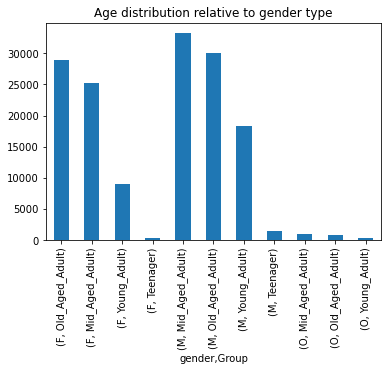

In [61]:
df.groupby('gender')['Group'].value_counts().plot.bar(title = 'Age distribution relative to gender type');

# Building an ML model to predict customer behavior to given offer types
## in this section we will do the following:
### 1- Prepare the data
### 2- Split & Train the data
### 3- Train & test the data
### 4- Draw conclusions

In [62]:
df.head()

,reward,channels,difficulty,duration,offer_type,Offer_ID,Customer_ID,event,time,Profit,Loss,gender,age,joining_date,Customer_income,Group
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,0,0.0,0.0,M,64,2017-09-09,100000.0,Old_Aged_Adult
1,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,102,0.0,0.0,M,64,2017-09-09,100000.0,Old_Aged_Adult
2,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer received,504,0.0,0.0,M,64,2017-09-09,100000.0,Old_Aged_Adult
3,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer viewed,510,0.0,0.0,M,64,2017-09-09,100000.0,Old_Aged_Adult
4,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,offer completed,510,10.0,0.0,M,64,2017-09-09,100000.0,Old_Aged_Adult


### We will change the following:
#### 1- change offer types into numerical categorization to be applicable in the normalization process
#### 2- remove joining date
#### 3- change Offer_ID and Customer_ID into numberical categorization to be applicabale in the normalization process
#### 4- Change the group column into numerical categorization to be applicable in the normalization process
#### 5- Scale and normalize the data

In [63]:
def prepare(df):
    """
    Prepare the dataframe to be fed into the model
    
    Parameters:
    df: Merged dataframe
    
    Return:
    
    df: prepared dataframe with the above mentioned adjusments
    """
    #Categorize offer type, gender and age groups
    variables = ['offer_type','gender','Group']
    df = pd.get_dummies(df, columns = variables)
    #joining the channels column to the above dummy and dropping the channels column
    df = df.drop('channels', 1).join(df.channels.str.join('|').str.get_dummies())
    
    #Preparing the Offer_ID column
    prep_offer_ID = df['Offer_ID'].unique().tolist()
    preped_offer = dict(zip(prep_offer_ID, range(len(prep_offer_ID))))
    df.replace({'Offer_ID': 'Preped_offer_ID'}, inplace = True)
    #Prepare the customer_ID column
    prep_customer_ID = df['Customer_ID'].unique().tolist()
    prepred_customer_ID = dict(zip(prep_customer_ID, range(len(prep_customer_ID))))
    df.replace({'Customer_ID':'Preped_Customer_ID'}, inplace = True)
    
    #Normalizing the event column:
    df['event'] = df['event'].map({'offer received':1,'offer viewed':2,'offer completed':3})
    #Creating a scaler to normalize the data (MinMaxScaler with min = 0 and max = 1)
    scaler = MinMaxScaler()
    data = ['duration','Customer_income','reward','time','Loss','Profit','difficulty']
    df[data] = scaler.fit_transform(df[data])
    
    return df
    
    

In [64]:
preped_data = prepare(df)

In [65]:
preped_data.head()

,reward,difficulty,duration,Offer_ID,Customer_ID,event,time,Profit,Loss,age,...,gender_M,gender_O,Group_Mid_Aged_Adult,Group_Old_Aged_Adult,Group_Teenager,Group_Young_Adult,email,mobile,social,web
0,1.0,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,1,0.000000,0.0,0.0,64,...,1,0,0,1,0,0,1,1,1,0
1,1.0,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,2,0.142857,0.0,0.0,64,...,1,0,0,1,0,0,1,1,1,0
2,1.0,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,1,0.705882,0.0,0.0,64,...,1,0,0,1,0,0,1,1,1,0
3,1.0,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,2,0.714286,0.0,0.0,64,...,1,0,0,1,0,0,1,1,1,0
4,1.0,0.5,0.571429,ae264e3637204a6fb9bb56bc8210ddfd,4b0da7e80e5945209a1fdddfe813dbe0,3,0.714286,1.0,0.0,64,...,1,0,0,1,0,0,1,1,1,0


In [66]:
preped_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   reward                    148805 non-null  float64       
 1   difficulty                148805 non-null  float64       
 2   duration                  148805 non-null  float64       
 3   Offer_ID                  148805 non-null  object        
 4   Customer_ID               148805 non-null  object        
 5   event                     148805 non-null  int64         
 6   time                      148805 non-null  float64       
 7   Profit                    148805 non-null  float64       
 8   Loss                      148805 non-null  float64       
 9   age                       148805 non-null  int64         
 10  joining_date              148805 non-null  datetime64[ns]
 11  Customer_income           148805 non-null  float64       
 12  of

In [67]:
preped_data.shape

(148805, 26)

In [68]:
preped_data.describe()

,reward,difficulty,duration,event,time,Profit,Loss,age,Customer_income,offer_type_bogo,...,gender_M,gender_O,Group_Mid_Aged_Adult,Group_Old_Aged_Adult,Group_Teenager,Group_Young_Adult,email,mobile,social,web
count,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000,...,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.000000,148805.0,148805.000000,148805.000000,148805.000000
mean,0.444244,0.394528,0.517887,1.771130,0.496597,0.107887,0.0,54.779282,0.404601,0.428978,...,0.557078,0.014717,0.399395,0.401741,0.012721,0.186143,1.0,0.917160,0.658311,0.806747
std,0.337236,0.252067,0.304719,0.782658,0.277747,0.245254,0.0,17.193533,0.238855,0.494932,...,0.496733,0.120419,0.489776,0.490252,0.112070,0.389223,0.0,0.275641,0.474277,0.394851
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,18.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
25%,0.200000,0.250000,0.285714,1.000000,0.235294,0.000000,0.0,43.000000,0.233333,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,0.000000,1.000000
50%,0.500000,0.500000,0.571429,2.000000,0.571429,0.000000,0.0,56.000000,0.388889,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000
75%,0.500000,0.500000,0.571429,2.000000,0.714286,0.000000,0.0,67.000000,0.566667,1.000000,...,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.0,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000,0.0,101.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000


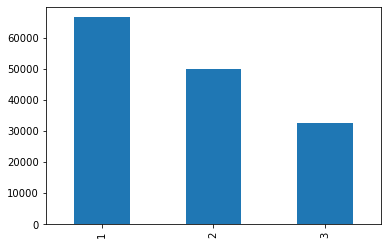

In [69]:
preped_data.event.value_counts().plot.bar("count of each event type");

### Split the train & test data

In [70]:
preped_data.drop('event', axis = 1)
labels = preped_data['event']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(preped_data, labels, test_size = 0.4, random_state = 0)

print("Size of training data: {}".format(X_train.shape[0]))
print("Size of testing data: {}".format(X_test.shape[0]))

Size of training data: 89283
Size of testing data: 59522


### Training the data

As mentioned in the proposal, I will use F1 Score as the model metric. The F1 score (the weighted average of the precision and recall) will be used for both the benchmark and evaluation model as it provides great assessment about the quality. The score will be between 0 and 1, giving zero to be the lowest quality and 1 to be the highest quality

In [72]:
def train_test(evaluator):
    """
    The function returned the F1 score and the model name to compare the accuracy
    
    Parameters
    
    evaluator: estimator instance
    
    Returns
    
    f1_train: f1 score of the trained data
    f1_test: f1 score of the tested data
    model_name: name of the used model
    
    """
    train_predictions = (evaluator.fit(X_train,y_train)).predict(X_train)
    test_predictions = (evaluator.fit(X_train, y_train)).predict(X_test)
    
    f1_train = accuracy_score(y_train, train_predictions)*100
    f1_test = fbeta_score(y_test, test_predictions, beta - 0., average = 'micro')*100
    model_name = evaluator.__.class__.__name__
    return f1_train, f1_test, model_name

    

### Applying the f1 score on a benchmark model (KNeighborsClassifier)

In [73]:
Evaluator_Benchmark = KNeighborsClassifier(n_neighbors= 5)
Benchmark_f1_train, Benchmark_f1_test, Benchmark_model = train_test(Evaluator_Benchmark)

ValueError: could not convert string to float: 'fafdcd668e3743c1bb461111dcafc2a4'